In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, platform, os
from matplotlib import pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

import camb
from camb import model, initialpower
import pandas as pd
import re

In [2]:
# Keep in mind that this is NOT the same file as the original "cosmology_Aletheia.dat"
# that Ariel gave us! If you use the unaltered version, you will get a segfault
cosm = pd.read_csv("cosmologies.dat", sep='\s+')

# The following code is somewhat hard;
# I'm not sure how better to do it.
redshift_column = re.compile("z.+")

In [29]:
def kzps(mlc, omnuh2_in, massive_neutrinos=False, zs = [0], nnu_massive_in=3):
    """
    Returns the scale axis, redshifts, power spectrum, and sigma12
    of a Lambda-CDM model
    @param mlc : "MassLess Cosmology"
        a dictionary of values
        for CAMBparams fields
    @param omnuh2_in : neutrino physical mass density
    @param sigma12 : if the spectrum should be rescaled,
        this parameter determines the desired sigma12 of the model
    @massive_neutrinos : if this is True,
        the value in omnuh2_in is used to set omnuh2.
        If this is False,
        the value in omnuh2_in is simply added to omch2.
    """ 
    pars = camb.CAMBparams()
    omch2_in = mlc["omch2"]
    mnu_in = 0
    
    # nnu_in = 3.046
    nnu_massive = 0
    if massive_neutrinos:
        # This is a horrible workaround, and I would like to get rid of it ASAP
        # The following line destroys dependence on TCMB and neutrino_hierarchy, possibly more
        mnu_in = omnuh2_in * camb.constants.neutrino_mass_fac / \
            (6.046 / 3.0) ** 0.75 
        # mnu_in = omnuh2_in * camb.constants.neutrino_mass_fac / (2.046 / 3) ** 0.75 
        
        omch2_in -= omnuh2_in
        nnu_massive = nnu_massive_in
    pars.set_cosmology(
        H0=mlc["h"] * 100,
        ombh2=mlc["ombh2"],
        omch2=omch2_in,
        omk=mlc["OmK"],
        mnu=mnu_in,
        num_massive_neutrinos=nnu_massive#,
        #neutrino_hierarchy="normal"
    )
    pars.InitPower.set_params(As=mlc["A_s"], ns=mlc["n_s"])
    
    #pars.DarkEnergy = camb.dark_energy.DarkEnergyPPF(w=mlc["w0"], wa=float(mlc["wa"]))
    pars.set_dark_energy(w=mlc["w0"], wa=float(mlc["wa"]), dark_energy_model='ppf')
    
    # The following bogus line can expose whether the simulation is paying attention to DE
    # (for some reason, the pair (-100, -100) did not look strange at all!) 
    # pars.set_dark_energy(w=-0, wa=0, dark_energy_model='ppf') 
    
    # To change the the extent of the k-axis,
    # change the following line as well as the "get_matter_power_spectrum" call
    pars.set_matter_power(redshifts=zs, kmax=10.0,
        nonlinear=False)#, accurate_massive_neutrino_transfers=True)
    #pars.NonLinear = model.NonLinear_none
    results = camb.get_results(pars)
    results.calc_power_spectra(pars)

    k, z, p = results.get_matter_power_spectrum(
        minkh=3e-3, maxkh=3.0, npoints = 10000,
        var1=8, var2=8
    )
    sigma12 = results.get_sigmaR(12, hubble_units=False)
    
    # The following line is helpful when debugging the mnu \ omnuh2 shenanigans
    #print("my nu density:", pars.omnuh2)
    
    return k, z, p, sigma12

In [30]:
from copy import deepcopy as dc
# z_in = parse_redshifts(0)
z_in = np.array([0]) # I don't see a redshift in the paper;
# are they always assuming z=0?

model0 = cosm.loc[0]

print(model0)

modelK = dc(model0)
# Now it's safe to modify this object into the Kiakotou stuff.
modelK["OmM"] = 0.25
modelK["OmB"] = 0.04
modelK["h"] = 0.7
omnuh2_in = modelK["OmM"] * 0.04

# Derived quantities
modelK["ombh2"] = modelK["OmB"] * modelK["h"] ** 2
OmCDM = modelK["OmM"] - modelK["OmB"]
modelK["omch2"] = OmCDM * modelK["h"] ** 2

print()
print(modelK)

Name      Columbus_0
ombh2       0.022445
omch2       0.120567
n_s             0.96
A_s              0.0
OmB             0.05
OmC         0.268584
OmM         0.318584
OmK              0.0
OmL         0.681416
h               0.67
w0              -1.0
wa              0.00
EOmDE              -
z(4)             2.0
z(3)             1.0
z(2)            0.57
z(1)             0.3
z(0)             0.0
Lbox          1000.0
sigma8       0.82755
Name: 0, dtype: object

Name      Columbus_0
ombh2         0.0196
omch2         0.1029
n_s             0.96
A_s              0.0
OmB             0.04
OmC         0.268584
OmM             0.25
OmK              0.0
OmL         0.681416
h                0.7
w0              -1.0
wa              0.00
EOmDE              -
z(4)             2.0
z(3)             1.0
z(2)            0.57
z(1)             0.3
z(0)             0.0
Lbox          1000.0
sigma8       0.82755
Name: 0, dtype: object


In [31]:
k0, z0, p0, s120 = kzps(modelK, omnuh2_in, massive_neutrinos=False, nnu_massive_in=1)

k1, z1, p1, s121 = kzps(modelK, omnuh2_in, massive_neutrinos=True, nnu_massive_in=1)

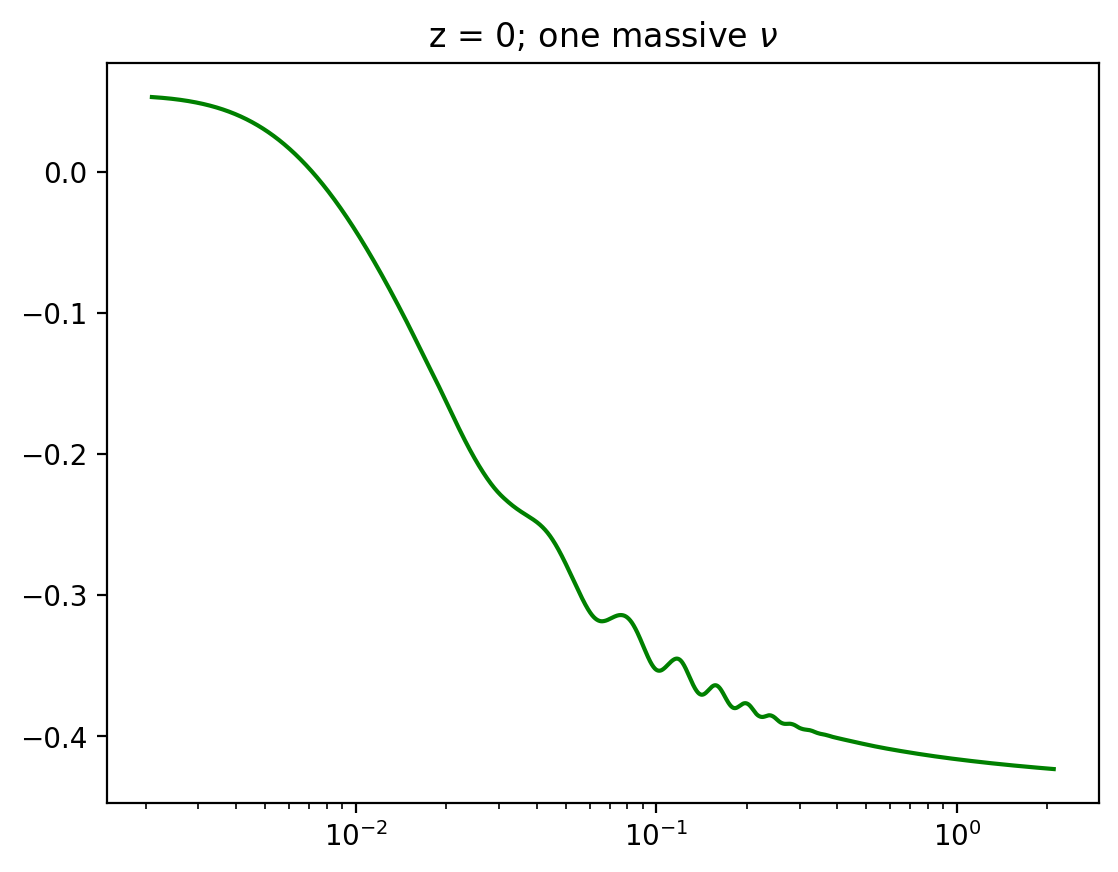

In [32]:
k_axis = k0 * modelK["h"]
p_axis = (p1[0] - p0[0]) / p0[0]

plt.title(r"z = 0; one massive $\nu$")
plt.plot(k_axis, p_axis, c="green")
plt.xscale("log")

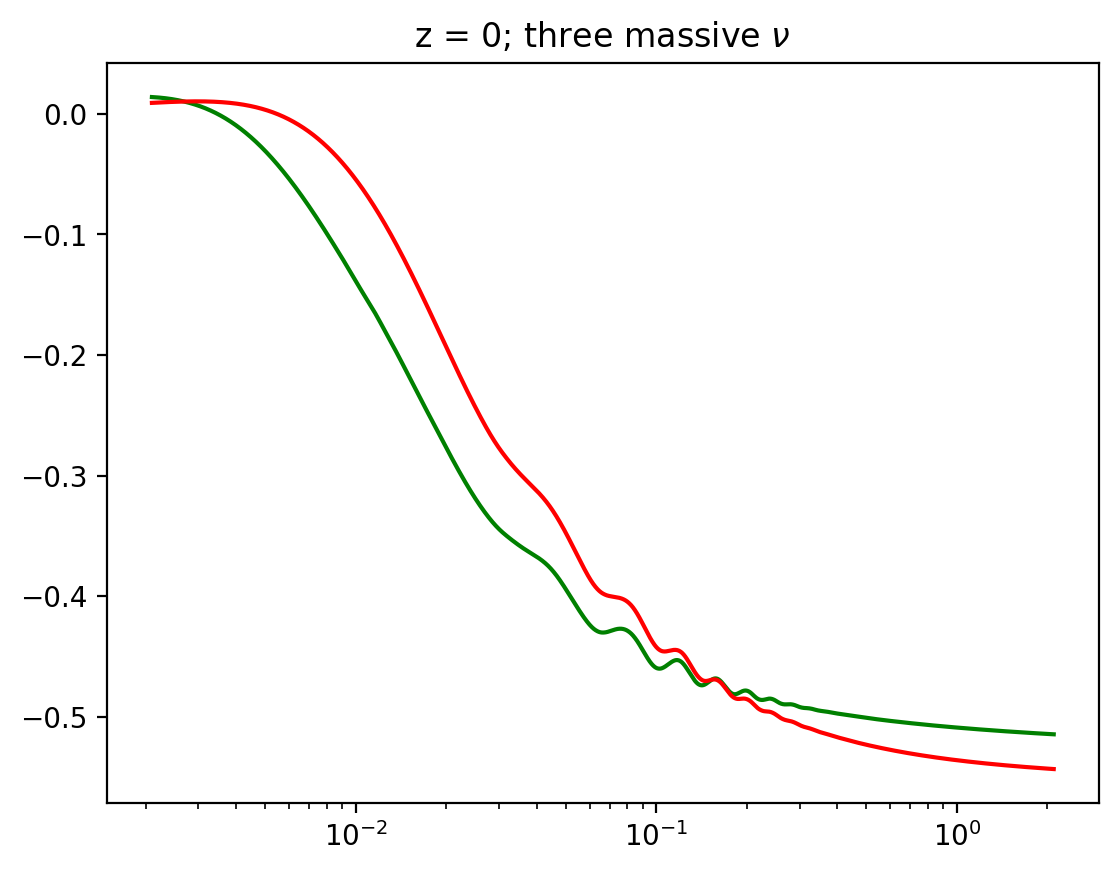

In [10]:
k3, z3, p3, s123 = kzps(modelK, omnuh2_in, massive_neutrinos=True, nnu_massive_in=3)
p3_axis = (p3[0] - p0[0]) / p0[0]
plt.title(r"z = 0; three massive $\nu$")
plt.plot(k_axis, p3_axis, c="green")
plt.plot(k_axis, p_axis, c="red")
plt.xscale("log")

What we haven't addressed yet:
* How do we amplitude-match the Kiakotou plots?